<a href="https://colab.research.google.com/github/SnSabu/congressional-analysis/blob/main/Python_Intro_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hypothesis: Younger people belonging to the 18-40 age bracket largely vote for Democrats

In [1]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

In [2]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.

url_Median_Age = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B01002_001E,B01002_002E,B01002_003E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url_Median_Age)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here:
# https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Median Age','Male Median Age', 'Female Median Age', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Median Age','Male Median Age', 'Female Median Age', 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()


,Median Age,Male Median Age,Female Median Age,district number,State
0,41.1,39.4,42.6,1,Alabama
1,39.2,37.9,40.7,2,Alabama
2,39.4,38.4,40.2,3,Alabama
3,40.7,39.5,42.0,4,Alabama
4,40.3,39.6,41.1,5,Alabama


In [3]:
# Convert the number columns into number data types so we can math on them
acs_df["Median Age"] = pd.to_numeric(acs_df["Median Age"])
acs_df["Male Median Age"] = pd.to_numeric(acs_df["Male Median Age"])
acs_df['Female Median Age'] = pd.to_numeric(acs_df['Female Median Age'])
# Compute some new columns based on the existing columns for later visualization
#acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Median Age']
#acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Median Age']

acs_df['Median Age Buckets'] = pd.cut(acs_df['Median Age'], bins = 5)

# now let's look at the data again
acs_df.head()

,Median Age,Male Median Age,Female Median Age,district number,State,Median Age Buckets
0,41.1,39.4,42.6,1,Alabama,"(39.8, 45.0]"
1,39.2,37.9,40.7,2,Alabama,"(34.6, 39.8]"
2,39.4,38.4,40.2,3,Alabama,"(34.6, 39.8]"
3,40.7,39.5,42.0,4,Alabama,"(39.8, 45.0]"
4,40.3,39.6,41.1,5,Alabama,"(39.8, 45.0]"


In [ ]:
acs_df.groupby('Median Age Buckets').size()

Median Age Buckets
(29.374, 34.6]     36
(34.6, 39.8]      231
(39.8, 45.0]      150
(45.0, 50.2]       17
(50.2, 55.4]        3
dtype: int64

In [4]:
acs_df.head()

,Median Age,Male Median Age,Female Median Age,district number,State,Median Age Buckets
0,41.1,39.4,42.6,1,Alabama,"(39.8, 45.0]"
1,39.2,37.9,40.7,2,Alabama,"(34.6, 39.8]"
2,39.4,38.4,40.2,3,Alabama,"(34.6, 39.8]"
3,40.7,39.5,42.0,4,Alabama,"(39.8, 45.0]"
4,40.3,39.6,41.1,5,Alabama,"(39.8, 45.0]"


In [5]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)


,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [6]:
party_df['State'].value_counts().head()

California      53
Texas           36
New York        27
Florida         27
Pennsylvania    18
Name: State, dtype: int64

In [7]:
acs_df['State'].value_counts().head()

California      53
Texas           36
Florida         27
New York        27
Pennsylvania    18
Name: State, dtype: int64

In [8]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [9]:
merged_df.head()

,Median Age,Male Median Age,Female Median Age,district number,State,Median Age Buckets,Party
0,41.1,39.4,42.6,1,Alabama,"(39.8, 45.0]",R
1,39.2,37.9,40.7,2,Alabama,"(34.6, 39.8]",R
2,39.4,38.4,40.2,3,Alabama,"(34.6, 39.8]",R
3,40.7,39.5,42.0,4,Alabama,"(39.8, 45.0]",R
4,40.3,39.6,41.1,5,Alabama,"(39.8, 45.0]",R


In [10]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

In [11]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]


In [12]:
R_Count = R.groupby('Median Age Buckets').size().reset_index(name="Count")
D_Count = D.groupby('Median Age Buckets').size().reset_index(name="Count")
L_Count = L.groupby('Median Age Buckets').size().reset_index(name="Count")

In [13]:
D_Count

,Median Age Buckets,Count
0,"(29.374, 34.6]",28
1,"(34.6, 39.8]",128
2,"(39.8, 45.0]",72
3,"(45.0, 50.2]",5
4,"(50.2, 55.4]",0


In [14]:
merged_df2 = pd.merge(pd.merge(R_Count,D_Count,on=["Median Age Buckets"]),L_Count,on=["Median Age Buckets"])
merged_df2 = merged_df2.rename(columns = {'Count_x': "Republican", 'Count_y': "Democrat", 'Count': "Libertarian"})
merged_df2

,Median Age Buckets,Republican,Democrat,Libertarian
0,"(29.374, 34.6]",8,28,0
1,"(34.6, 39.8]",101,128,1
2,"(39.8, 45.0]",77,72,0
3,"(45.0, 50.2]",12,5,0
4,"(50.2, 55.4]",3,0,0


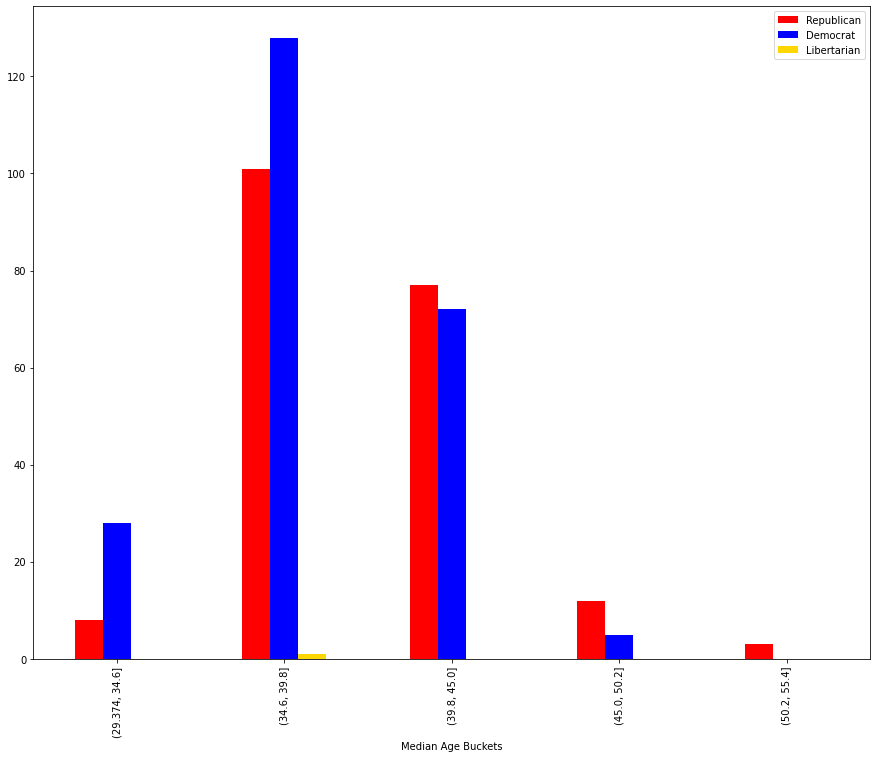

In [15]:
fig, ax = plt.subplots(figsize=(15, 12))
merged_df2.plot(kind = "bar", x='Median Age Buckets', color=['red', 'blue', 'gold'], ax=ax)
plt.show()

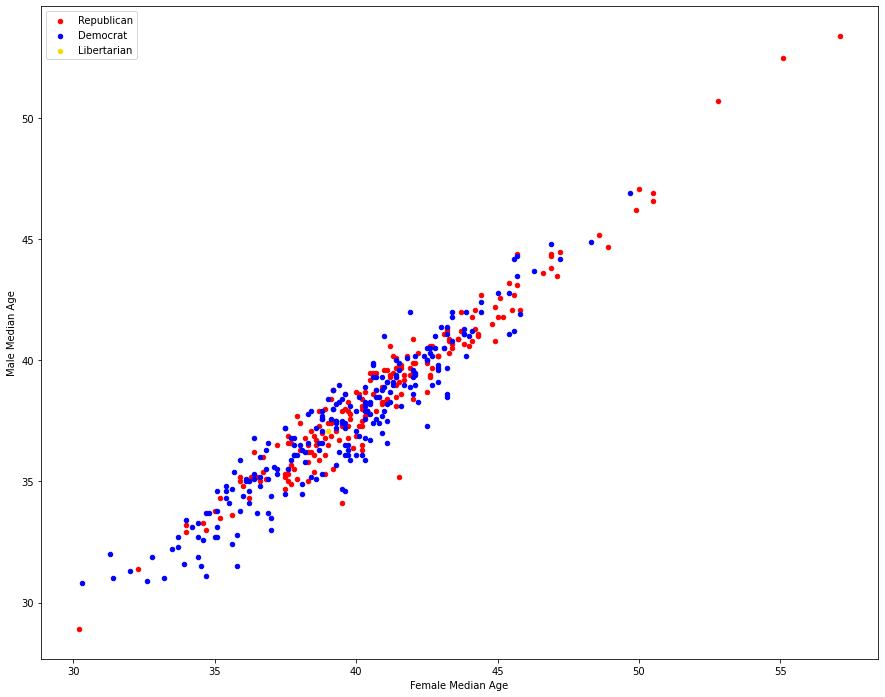

In [16]:
fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Female Median Age', y='Male Median Age', c='red',label='Republican', ax=ax)
D.plot.scatter(x='Female Median Age', y='Male Median Age',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Female Median Age', y='Male Median Age',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

Our initial hypothesis was to check whether people of ages who voted for democrats maximally, irrespective of gender, belonged to 25-40 age bracket.
We wanted to test this hypothesis as people voting for democrats generally belong to a more liberal sense of thought, and belong to later generations.
To test this hypothesis, we explored the median-age dataset. We cleaned the data, later bucketed the median ages into five groups.
The graph showed us that people belonging to 25-40 age bracket mostly voted for democrats, and people who were 45 plus, voted in maximum for the republican party. Thus, our hypothesis turned out to be right.
We also plotted a scatter plot of median-ages of male Vs median-ages of female to gain a better understanding. We could see that females of median-age 50 and above, and males of 45 and above, voted for republicans.
Thus, our hypothesis stands to be true that people belonging to the later generations vote for the democrats.     